### importing packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
path = "../aerial-cactus-identification"

In [2]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from PIL import Image
from keras.preprocessing import image
from keras import optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


### Setting directories

In [3]:
# setting directories
train_dir = '/input/train/'
test_dir = '/input/test/'
train = pd.read_csv('train.csv')

### Exploring the dataset

In [4]:
# explore the data
train.head(10)                # when image contains cactus 1, otherwise 0

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
5,0017c3c18ddd57a2ea6f9848c79d83d2.jpg,1
6,002134abf28af54575c18741b89dd2a4.jpg,0
7,0024320f43bdd490562246435af4f90b.jpg,0
8,002930423b9840e67e5a54afd4768a1e.jpg,1
9,00351838ebf6dff6e53056e00a1e307c.jpg,1


In [5]:
train.dtypes                  # check the data type

id            object
has_cactus     int64
dtype: object

In [6]:
train.has_cactus = train.has_cactus.apply(str)   # since the column is not about integer values, 
train.dtypes                  # change the column data type to string

id            object
has_cactus    object
dtype: object

17500
1    13136
0     4364
Name: has_cactus, dtype: int64


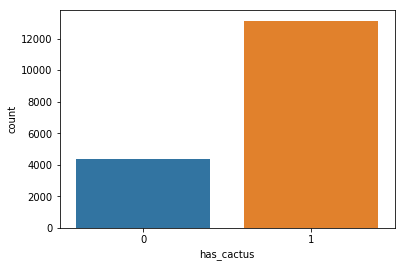

In [7]:
print(len(train))                              # number of observation: 17,500
print(train['has_cactus'].value_counts() )     # count the number of images containing cactus
sns.countplot(x='has_cactus', data=train)      # plot the output

In [8]:
# check the test dataset size
print('the number of rows in test set:', len(os.listdir(path+test_dir)))

the number of rows in test set: 4000


### Showing the random images

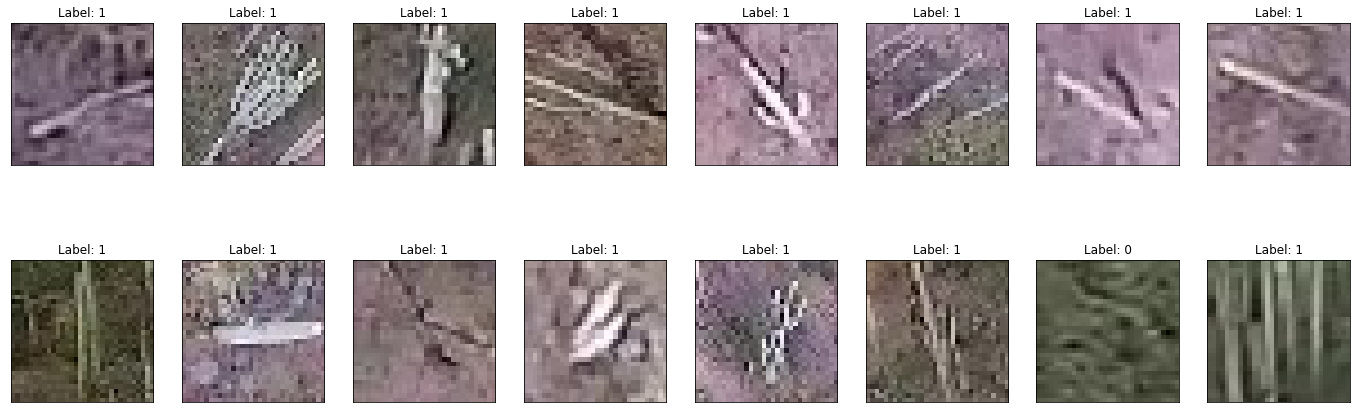

In [9]:
fig = plt.figure(figsize=(24, 8))
for idx, img in enumerate(np.random.choice(os.listdir(path+train_dir), 16)):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    im = Image.open(path+train_dir+ img)
    plt.imshow(im)
    lab = train.loc[train['id'] == img, 'has_cactus'].values[0]
    ax.set_title(f'Label: {lab}')

### Preparing the dataset

In [10]:
data = ImageDataGenerator(rescale=1./255)
batch_size = 100

<b> flow_from_dataframe method </b> can directly pass the Pandas DataFrame which has the mapping between filenames of the images and their labels. <br>
The flow_from_dataframe accepts all the arguments that flow_from_directory accepts,and obvious mandatory arguments like
- dataframe- Pandas DataFrame which contains the filenames and classes or numeric data to be treated as target values.
- directory- Path to the folder which contains all the images,None if x_col contains absolute paths pointing to each image instead of just filenames.
- x_col- The column in the dataframe that has the filenames of the images
- y_col- The column/columns in the dataframe in the filename that will be treated as raw target values if class_mode=”raw” (useful for regression tasks) or they will be treated as name of the classes if class_mode is “binary”/”categorical” or they will be ignored if class_mode is “input”/None.
- class_mode- In addition to all the class_modes previously available in flow_from_directory, there is “raw”.
- drop_duplicates- Boolean, whether to drop duplicate rows based on filename,True by default. <br>

Source: https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1


In [11]:
# Split the dataset into training and validation sets
train_generator=data.flow_from_dataframe(dataframe=train[:15001],
                                         directory=path+train_dir,
                                         x_col='id',
                                         y_col='has_cactus',
                                         class_mode='binary',
                                         batch_size=batch_size,
                                         target_size=(150,150))

val_generator=data.flow_from_dataframe(dataframe=train[15000:],
                                         directory=path+train_dir,
                                         x_col='id',
                                         y_col='has_cactus',
                                         class_mode='binary',
                                         batch_size=batch_size,
                                         target_size=(150,150))

Found 15001 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


### Building models

In [12]:
# build a model
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)             0         
__________

In [14]:
# compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizers.adam(), metrics=['acc'])

In [15]:
# train the model 
model_fit = model.fit_generator(train_generator,steps_per_epoch=100,epochs=5,
                                validation_data = val_generator,validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
100/100 [==============================] - 305s 3s/step - loss: 0.3208 - acc: 0.8927 - val_loss: 0.2162 - val_acc: 0.9124
Epoch 2/5
100/100 [==============================] - 314s 3s/step - loss: 0.1519 - acc: 0.9436 - val_loss: 0.1018 - val_acc: 0.9616
Epoch 3/5
100/100 [==============================] - 322s 3s/step - loss: 0.0938 - acc: 0.9659 - val_loss: 0.0871 - val_acc: 0.9664
Epoch 4/5
100/100 [==============================] - 333s 3s/step - loss: 0.0728 - acc: 0.9723 - val_loss: 0.0640 - val_acc: 0.9768
Epoch 5/5
100/100 [==============================] - 333s 3s/step - loss: 0.0538 - acc: 0.9798 - val_loss: 0.0800 - val_acc: 0.9684


In [16]:
# Evaluate the model 
def plot_metric(df, col, val_col, label, val_label):
    acc = df.history[col]
    epo = range(0, 5)
    plt.plot(epo, acc, label=label)
    
    val_col=df.history[val_col]
    plt.scatter(epo, val_col, label=val_label, c='red')
    plt.xlabel('# of epochs')
    plt.ylabel('Accuracy')
    plt.legend()

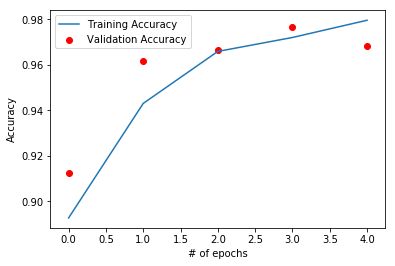

In [17]:
plot_metric(model_fit,'acc', 'val_acc','Training Accuracy', 'Validation Accuracy') 

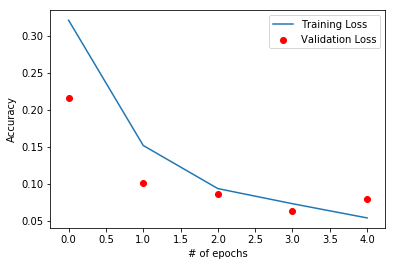

In [18]:
plot_metric(model_fit,'loss', 'val_loss','Training Loss', 'Validation Loss') 

### AlexNet

In [19]:
# Create a sequential model
alex_model = Sequential()

alex_model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='same',   # 1st Conv Layer
         input_shape=(150,150,3)))
alex_model.add(Activation('relu'))
alex_model.add(BatchNormalization())                                                    # used Batch Normalization(instead of LRN)
alex_model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))           # Pooling
                                             

alex_model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))  # 2nd Conv Layer
alex_model.add(Activation('relu'))
alex_model.add(BatchNormalization())                                                    # used Batch Normalization(instead of LRN)
alex_model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))           # Pooling

alex_model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))  # 3rd Conv Layer
alex_model.add(Activation('relu'))

alex_model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))  # 4th Conv Layer
alex_model.add(Activation('relu'))

alex_model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))  # 5th Conv Layer
alex_model.add(Activation('relu'))

# Pass it to a dense layer
alex_model.add(Flatten())

alex_model.add(Dense(4096, input_shape=(224*224*3,)))        # 1st Dense Layer
alex_model.add(Activation('relu'))
alex_model.add(Dropout(0.5))                                 # Dropout
alex_model.add(BatchNormalization())                         # Batch Normalization

alex_model.add(Dense(4096))                                  # 2nd Dense Layer
alex_model.add(Activation('relu'))
alex_model.add(Dropout(0.5))                                 # Dropout
alex_model.add(BatchNormalization())                         # Batch Normalization

alex_model.add(Dense(1000))                                  # 3rd Dense Layer
alex_model.add(Activation('relu'))
alex_model.add(Dropout(0.5))                                 # Dropout
alex_model.add(BatchNormalization())                         # Batch Normalization

alex_model.add(Dense(1))                                     # Output Layer
alex_model.add(Activation('sigmoid'))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
alex_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 38, 38, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 38, 38, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 38, 38, 96)        384       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 18, 256)       614656    
_________________________________________________________________
activation_2 (Activation)    (None, 18, 18, 256)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 18, 18, 256)       1024      
__________

In [21]:
# Compile the model
alex_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
# Train the model
# can increase stpes_per_epoch and epcchs if you want to obtain the higher performance
alex_model_fit = alex_model.fit_generator(train_generator,steps_per_epoch=20,epochs=5,
                                 validation_data=val_generator,validation_steps=10)

Epoch 1/5
20/20 [==============================] - 178s 9s/step - loss: 0.6045 - acc: 0.7915 - val_loss: 3.7990 - val_acc: 0.7580
Epoch 2/5
20/20 [==============================] - 166s 8s/step - loss: 0.3114 - acc: 0.9050 - val_loss: 1.0013 - val_acc: 0.7840
Epoch 3/5
20/20 [==============================] - 189s 9s/step - loss: 0.2013 - acc: 0.9370 - val_loss: 12.2498 - val_acc: 0.2400
Epoch 4/5
20/20 [==============================] - 173s 9s/step - loss: 0.1839 - acc: 0.9415 - val_loss: 1.2365 - val_acc: 0.7470
Epoch 5/5
20/20 [==============================] - 239s 12s/step - loss: 0.1742 - acc: 0.9454 - val_loss: 0.3659 - val_acc: 0.8760


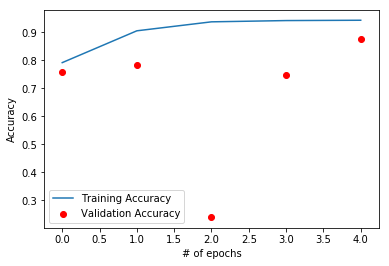

In [23]:
plot_metric(alex_model_fit,'acc', 'val_acc','Training Accuracy', 'Validation Accuracy')

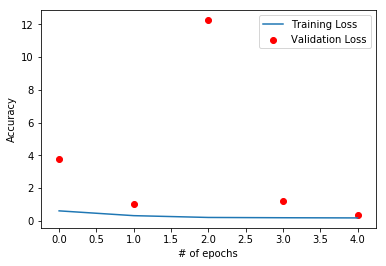

In [24]:
plot_metric(alex_model_fit,'loss', 'val_loss','Training Loss', 'Validation Loss')

### GoogLeNet - Inception V3

In [25]:
inception_model = InceptionV3(weights = "imagenet", include_top=False, input_shape = (150, 150, 3))

In [26]:
inception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 74, 74, 32)   96          conv2d_9[0][0]                   
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 74, 74, 32)   0           batch_normalization_6[0][0]      
__________________________________________________________________________________________________
conv2d_10 

In [27]:
# add fully connected layers with regularization 
x = inception_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)

# create the final model 
inception_model_final =  Model(inputs=inception_model.input, outputs=predictions)

In [28]:
# compile the model
inception_model_final.compile(loss='binary_crossentropy',optimizer=optimizers.adam(),metrics=['acc'])

In [29]:
# train the model
# can increase stpes_per_epoch and epcchs if you want to obtain the higher performance
inception_model_fit = inception_model_final.fit_generator(train_generator,steps_per_epoch=10,epochs=5,
                                            validation_data=val_generator,validation_steps=10)

Epoch 1/5
10/10 [==============================] - 273s 27s/step - loss: 0.7793 - acc: 0.7840 - val_loss: 3.3585 - val_acc: 0.6420
Epoch 2/5
10/10 [==============================] - 209s 21s/step - loss: 0.1293 - acc: 0.9620 - val_loss: 0.2873 - val_acc: 0.9290
Epoch 3/5
10/10 [==============================] - 190s 19s/step - loss: 0.0665 - acc: 0.9830 - val_loss: 0.0683 - val_acc: 0.9860
Epoch 4/5
10/10 [==============================] - 193s 19s/step - loss: 0.0691 - acc: 0.9820 - val_loss: 0.1857 - val_acc: 0.9400
Epoch 5/5
10/10 [==============================] - 189s 19s/step - loss: 0.0641 - acc: 0.9770 - val_loss: 0.2609 - val_acc: 0.9660


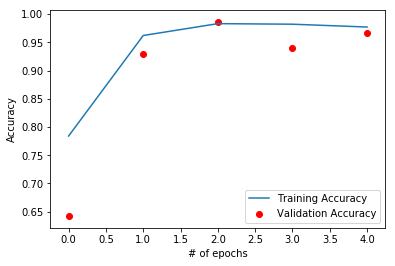

In [30]:
plot_metric(inception_model_fit,'acc', 'val_acc','Training Accuracy', 'Validation Accuracy') 

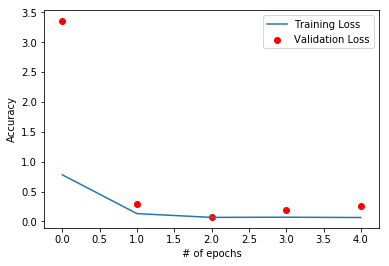

In [31]:
plot_metric(inception_model_fit,'loss', 'val_loss','Training Loss', 'Validation Loss') 

### ResNet 50

In [32]:
resnet_model = ResNet50(weights = "imagenet", include_top=False, input_shape = (150, 150, 3))

C:\Users\josep\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [33]:
resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [34]:
# add fully connected layers with regularization 
x = resnet_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)

# create the final model 
resnet_model_final =  Model(inputs=resnet_model.input, outputs=predictions)

In [35]:
# compile the model
resnet_model_final.compile(loss='binary_crossentropy', optimizer=optimizers.adam(),metrics=['acc'])

In [36]:
# train the model
# can increase stpes_per_epoch and epcchs if you want to obtain the higher performance
resnet_model_fit= resnet_model_final.fit_generator(train_generator,steps_per_epoch=10,epochs=5,  
                                    validation_data=val_generator,validation_steps=10)

Epoch 1/5
10/10 [==============================] - 508s 51s/step - loss: 1.1867 - acc: 0.7800 - val_loss: 3.7997 - val_acc: 0.7540
Epoch 2/5
10/10 [==============================] - 448s 45s/step - loss: 0.1364 - acc: 0.9580 - val_loss: 0.8254 - val_acc: 0.8710
Epoch 3/5
10/10 [==============================] - 435s 44s/step - loss: 0.0845 - acc: 0.9740 - val_loss: 2.2266 - val_acc: 0.8370
Epoch 4/5
10/10 [==============================] - 451s 45s/step - loss: 0.0627 - acc: 0.9740 - val_loss: 0.6472 - val_acc: 0.9380
Epoch 5/5
10/10 [==============================] - 397s 40s/step - loss: 0.0792 - acc: 0.9770 - val_loss: 0.7712 - val_acc: 0.9170


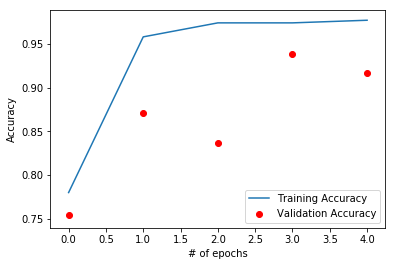

In [37]:
plot_metric(resnet_model_fit,'acc', 'val_acc','Training Accuracy', 'Validation Accuracy')

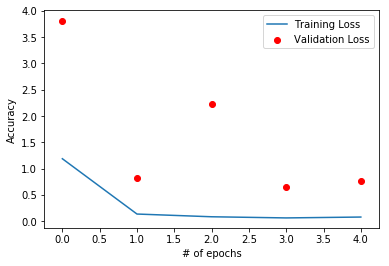

In [38]:
plot_metric(resnet_model_fit,'loss', 'val_loss','Training Loss', 'Validation Loss')

## End